In [1]:
import pandas as pd

In [2]:
pd.__version__

'2.1.1'

In [3]:
#! pip install pyarrow

In [4]:
df_jan = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet', engine='pyarrow')

In [5]:
df_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet', engine='pyarrow')

In [6]:
df_jan.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0


In [7]:
df_feb.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-02-01 00:04:45,2024-02-01 00:19:58,1.0,4.39,1.0,N,68,236,1,20.5,1.0,0.5,1.28,0.0,1.0,26.78,2.5,0.0
1,2,2024-02-01 00:56:31,2024-02-01 01:10:53,1.0,7.71,1.0,N,48,243,1,31.0,1.0,0.5,9.00,0.0,1.0,45.00,2.5,0.0


In [8]:
assert (df_jan.columns == df_feb.columns).all(), "Not same schema"

In [9]:
df_jan.shape

(2964624, 19)

In [10]:
df_feb.shape

(3007526, 19)

### Q1 Read the data for January. How many columns are there?

#### Answer Q1 : 19  colums

### Q2 Computing duration : What's the standard deviation of the trips duration in January?



In [11]:
# duration in minutes : dropoff - pickup

df_jan["duration"] = (df_jan.tpep_dropoff_datetime - df_jan.tpep_pickup_datetime).dt.total_seconds() / 60

In [12]:
df_jan.duration

0          19.800000
1           6.600000
2          17.916667
3           8.300000
4           6.100000
             ...    
2964619     8.616667
2964620    14.750000
2964621    19.000000
2964622    17.850000
2964623    15.083333
Name: duration, Length: 2964624, dtype: float64

In [13]:
df_jan.duration.describe()

count    2.964624e+06
mean     1.561295e+01
std      3.485105e+01
min     -1.356667e+01
25%      7.150000e+00
50%      1.163333e+01
75%      1.868333e+01
max      9.455400e+03
Name: duration, dtype: float64

#### Answer  Q2: Around 34 so the closest answer is 32.59 

### Q3. Dropping outliers : What fraction of the records left after you dropped the outliers?

In [14]:
import numpy as np 
df_jan["outlier"] = np.logical_or(df_jan.duration <1, df_jan.duration >60)


In [15]:
df_jan.outlier.value_counts(normalize=True) * 100

outlier
False    97.78326
True      2.21674
Name: proportion, dtype: float64

#### Answer Q3 : Around 98% of the original dataset.

In [16]:
# removing outlier
df_jan = df_jan[~df_jan.outlier].reset_index(drop=True)
# dropping outlier column
df_jan = df_jan.drop(columns=["outlier"])

In [17]:
df_jan.shape

(2898906, 20)

### Q4: One hot encoding

In [18]:
categorical_features = ['PULocationID','DOLocationID']
target_column = ["duration"] 
used_columns = categorical_features + target_column


df_jan_used = df_jan[used_columns].copy()

In [19]:
df_jan_used.head()

,PULocationID,DOLocationID,duration
0,186,79,19.800000
1,140,236,6.600000
2,236,79,17.916667
3,79,211,8.300000
4,211,148,6.100000


In [20]:
df_jan_used[categorical_features] = df_jan_used[categorical_features].astype(str)

In [21]:
df_jan_used.dtypes

PULocationID     object
DOLocationID     object
duration        float64
dtype: object

In [22]:

features_dict = df_jan_used[categorical_features].to_dict(orient='records')

In [23]:
features_dict[:2]

[{'PULocationID': '186', 'DOLocationID': '79'},
 {'PULocationID': '140', 'DOLocationID': '236'}]

In [24]:
from sklearn.feature_extraction import DictVectorizer

In [25]:
dv = DictVectorizer()
vectorized_features = dv.fit_transform(features_dict)


In [26]:
# df_encoded = pd.get_dummies(data=df_jan_used, prefix_sep="_", dtype=float)

In [27]:
vectorized_features[:1, :].toarray().size

518

In [28]:
print(len(dv.feature_names_))

518


#### Answer Q4 : Here we get 518 features so the closed solution is 515

## Modeling

In [29]:
X_train = vectorized_features

In [30]:
y_train = df_jan_used[target_column].values.reshape(-1)
y_train

array([19.8       ,  6.6       , 17.91666667, ..., 19.        ,
       17.85      , 15.08333333])

#### Feature engineering pipeline

In [31]:


class DurationDataProcessor:

    def compute_duration(self, X):
        try:
            X_transformed = X.copy()
            X_transformed["duration"] = X_transformed["tpep_dropoff_datetime"] - X_transformed["tpep_pickup_datetime"]
            X_transformed["duration"] = X_transformed["duration"].dt.total_seconds() / 60
            return X_transformed
        except Exception as e:
            return f"The following error occured: {e}."

    def remove_outlier(self, X, test_column, lower_bound=1, upper_bound=60, y=None):
        X_transformed = X.copy()
        try:
            X_transformed = X_transformed[(X_transformed[test_column]>= lower_bound) & (X_transformed[test_column] <= upper_bound)]
            return X_transformed
        except Exception as e:
            return f"The following error occured: {e}."
        
    def extract_features_target(self, X, used_features:list[str], target_column: str, y=None):
        try:
            dv = DictVectorizer()
            X_transformed = X.copy()
            if not target_column in X_transformed.columns:
                X_transformed = self.compute_duration(X_transformed)
                target_column = "duration"
            used_columns = used_features + [target_column]
            X_transformed = X_transformed[used_columns].copy()
            # remove outlier
            X_transformed = self.remove_outlier(X=X_transformed, test_column=target_column)
            y = X_transformed[target_column].copy().values
            X_transformed_features = X_transformed[used_features].astype(str)
            X_transformed_dict = X_transformed_features.to_dict(orient='records')
            X_transformed_vectorized = dv.fit_transform(X_transformed_dict)
            del X_transformed, X_transformed_dict, X_transformed_features
            return X_transformed_vectorized, y, dv
        
        except Exception as e:
            return f"The following error occured: {e}."

Processor = DurationDataProcessor()

In [32]:
X_train, y_train, dv_jan = Processor.extract_features_target(X=df_jan, used_features=categorical_features, target_column="duration")

In [33]:
len(dv_jan.feature_names_)

518

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
lr = LinearRegression()

In [36]:
lr.fit(X_train, y_train)

LinearRegression()

In [37]:
y_train_pred = lr.predict(X_train)

In [38]:
y_train_pred

array([14.04116956, 11.68879021, 10.75228215, ..., 22.41058992,
       16.06033693, 24.66931708])

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/2m/ys1b248x6l93pxxf85kdct740000gn/T/ipykernel_28900/3566353440.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_pred, label="prediction")
/var/folders/2m/ys1b248x6l93pxxf85kdct740000gn/T/ipykernel_28900/3566353440.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_trai

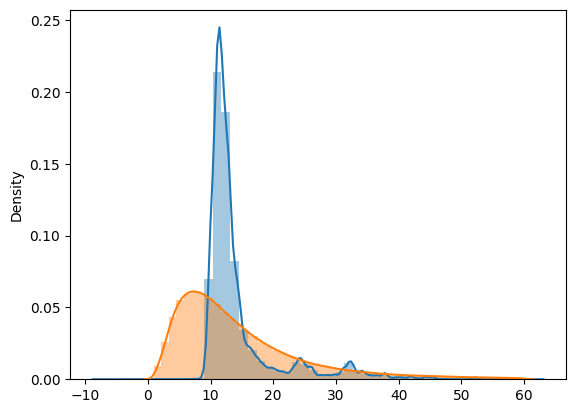

In [40]:
sns.distplot(y_train_pred, label="prediction")
sns.distplot(y_train, label="actual")
plt.show()

/var/folders/2m/ys1b248x6l93pxxf85kdct740000gn/T/ipykernel_28900/2633642235.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="actual")


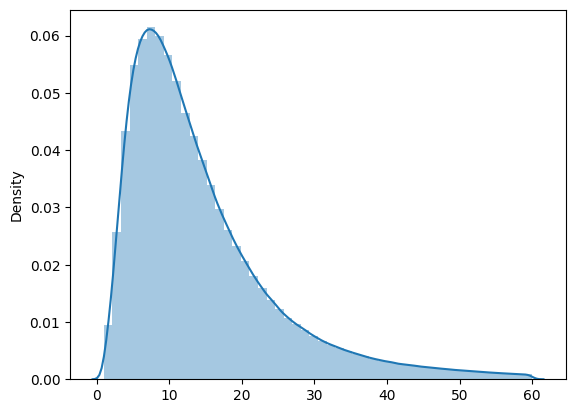

In [41]:
sns.distplot(y_train, label="actual")
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

print(f"MSE on train : {mse_train}")
print(f"RMSE on train : {rmse_train}")

MSE on train : 63.141689159156314
RMSE on train : 7.94617449840842


#### Answer Q5:  RMSE is 7.94

### Q6 Evaluating the model

In [44]:
X_feb, y_feb, dv_feb = Processor.extract_features_target(X=df_feb, used_features=categorical_features, target_column="duration")

In [46]:
X_feb

<2938060x514 sparse matrix of type '<class 'numpy.float64'>'
	with 5876120 stored elements in Compressed Sparse Row format>